In [ ]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
import spacy
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from transformers import BertTokenizer, BertModel, pipeline, AutoTokenizer
from joblib import dump, load
import torch
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [ ]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

En este apartado exploraremos el dataset para entender mejor su estructura y características.

**Distribución de clases**

Primero quitaremos aquellos datos que estén duplicados para después visualizar su distribución, si están balanceados o no.

In [ ]:
print("Existen {} documentos duplicadas".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates(subset=["tweet_text"])
print("Despues de quitar duplicados tenemos un conjunto de {} documentos".format(dataset.shape[0]))

Existen 1675 documentos duplicadas
Despues de quitar duplicados tenemos un conjunto de 46017 documentos


Comprobaramos que no hayan quedado Nulls en ningunas de las dos columnas del dataset.

In [ ]:
print("Hay {} valores vacíos en los tweets y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en los tweets y 0 valores vacíos en las etiquetas en los datos


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
<ipython-input-6-0e0cbc15141b>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Hay {} valores vacíos en los tweets y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
<ipython-input-6-0e0cbc15141b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n

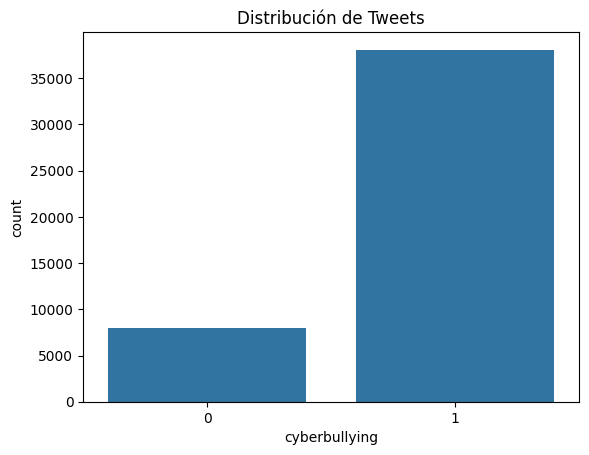

Número total de documentos: 46017
Número de documentos SIN 'cyberbullying': 7937
Número de documentos CON 'cyberbullying': 38080


In [ ]:
# Distribución de la variable objetivo
sns.countplot(x='cyberbullying', data=dataset)
plt.title('Distribución de Tweets')
plt.show()

# Número de documentos
print(f"Número total de documentos: {len(dataset)}")
print(f"Número de documentos SIN 'cyberbullying': {len(dataset[dataset['cyberbullying'] == 0])}")
print(f"Número de documentos CON 'cyberbullying': {len(dataset[dataset['cyberbullying'] == 1])}")

Como podemos ver en el gráfico de barras, **más del 80% de los tweets contienen mensajes de odio**.

Pasamos a comprobar su longitud de caracteres. Dividiremos los tweets en "tweets con cyberbullying" y "tweets sin cyberbullying" a ver si existe alguna diferencia significativa entre la longitud de ambos tipos.

<ipython-input-8-e5a9e966e9be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_con_cb['length'] = tweets_con_cb['tweet_text'].apply(len)
<ipython-input-8-e5a9e966e9be>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_sin_cb['length'] = tweets_sin_cb['tweet_text'].apply(len)


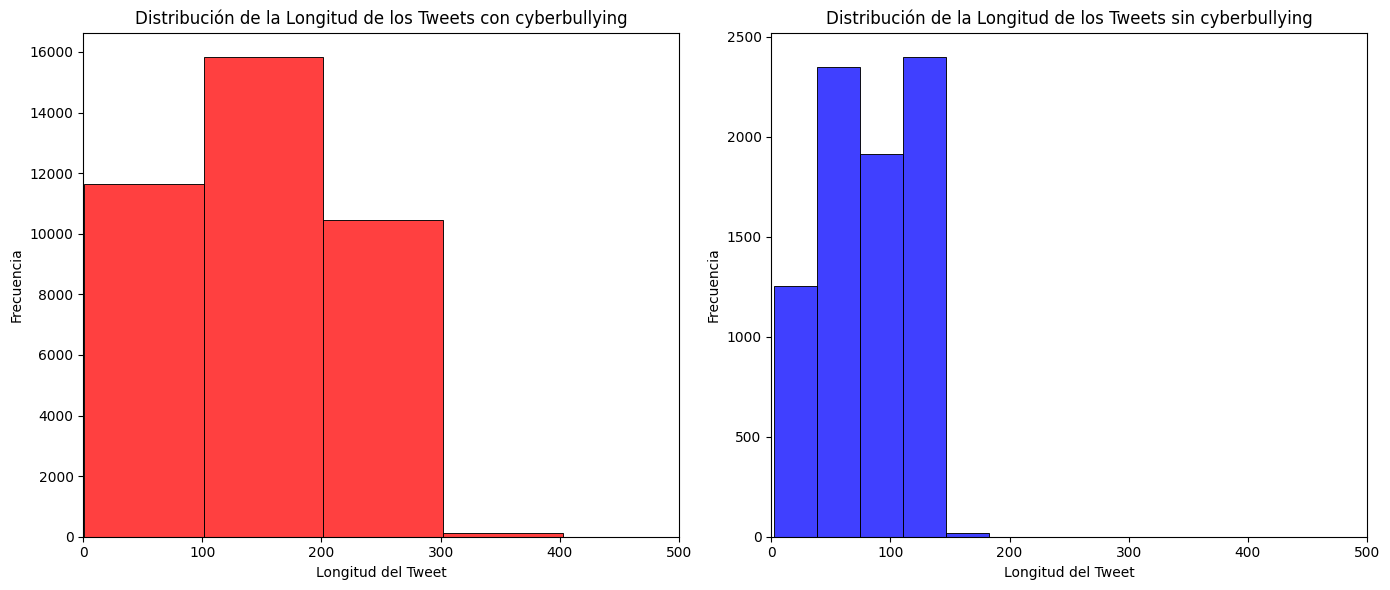

In [ ]:
# Filtramos los tweets con y sin cyberbullying
tweets_con_cb = dataset[dataset['cyberbullying'] == 1]
tweets_sin_cb = dataset[dataset['cyberbullying'] == 0]

# Añadimos columnas con la longitud de los tweets
tweets_con_cb['length'] = tweets_con_cb['tweet_text'].apply(len)
tweets_sin_cb['length'] = tweets_sin_cb['tweet_text'].apply(len)

# Creamos los gráficos
plt.figure(figsize=(14, 6))

# Gráfico para tweets con cyberbullying
plt.subplot(1, 2, 1)
sns.histplot(tweets_con_cb['length'], bins=50, color='red')
plt.xlim(0, 500)
plt.title('Distribución de la Longitud de los Tweets con cyberbullying')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')

# Gráfico para tweets sin cyberbullying
plt.subplot(1, 2, 2)
sns.histplot(tweets_sin_cb['length'], bins=50, color='blue')
plt.xlim(0, 500)
plt.title('Distribución de la Longitud de los Tweets sin cyberbullying')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')

# Mostramos los gráficos
plt.tight_layout()
plt.show()

In [ ]:
print(f"Longitud media de tweets con cyberbullying: {round(tweets_con_cb['length'].mean(), 2)}")
print(f"Longitud media de tweets sin cyberbullying: {round(tweets_sin_cb['length'].mean(), 2)}")

Longitud media de tweets con cyberbullying: 149.58
Longitud media de tweets sin cyberbullying: 83.09


Los gráficos nos muestran que los tweets más largos suelen estar relacionados con el cyberbullying. De hecho, **todos los tweets de nuestro dataset que supera los 200 caracteres contienen mensajes de odio**.

**WordCloud**

Ahora pasaremos a crear un wordcloud para ver de forma rápida cuáles son aquellas palabras que más destacan en los dos tipos de tweets.

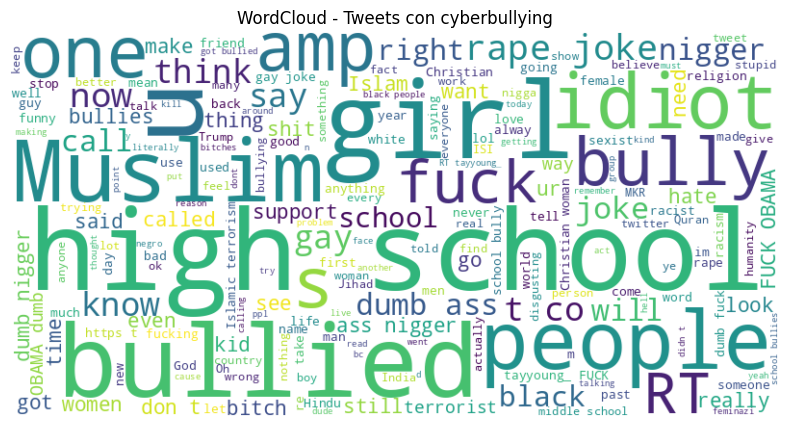

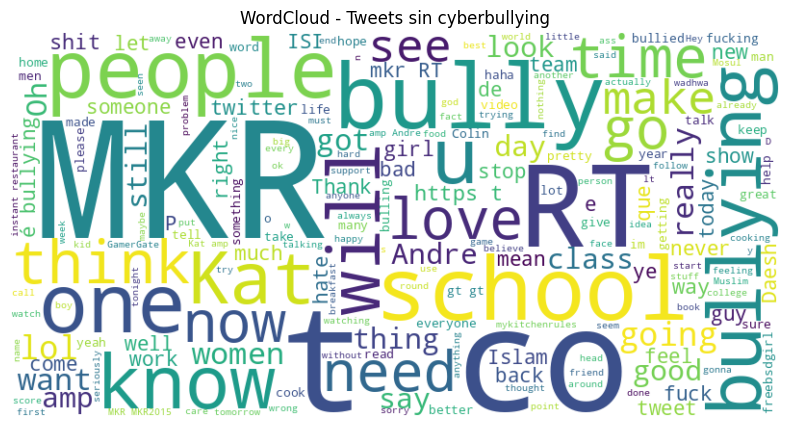

In [ ]:
# WordCloud para tweets con cyberbullying
hate_speech = ' '.join(dataset[dataset['cyberbullying'] == 1]['tweet_text'])
wordcloud_hate = WordCloud(width=800, height=400, background_color='white').generate(hate_speech)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.title('WordCloud - Tweets con cyberbullying')
plt.axis('off')
plt.show()

# WordCloud para tweets sin cyberbullying
non_hate_speech = ' '.join(dataset[dataset['cyberbullying'] == 0]['tweet_text'])
wordcloud_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_speech)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_hate, interpolation='bilinear')
plt.title('WordCloud - Tweets sin cyberbullying')
plt.axis('off')
plt.show()

Las palabras que podemos ver más a simple vista son:
  
  *En tweets con cyberbullying*: 'bullied', 'high school, 'muslim', 'idiot' y 'girl'.
  *En tweets sin cyberbullying*: 'MKR', 'RT', 't co', 'school' y 'bully'.

Podemos ver cómo hay palabras como 'bully', 'school' o 'girl', entre otras, que se usan en los dos ámbitos.

Llama la atención que 'bully' sea más usado en tweets sin odio que con odio. En cambio, en tweets con cyberbullying es más común usar la palabra 'bullied'.

## 3. Preprocesado y Normalización

Pasaremos a normalizar y limpiar el texto antes de que sea usado por un modelo de clasificación. Con ello,  reduciremos la dimensionalidad del texto y mejoraremos la capacidad de nuestro futuro modelo para generalizar.

**Eliminar StopWords y signos de puntuación**

In [ ]:
# Preprocesamiento de texto
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Función para eliminar stopwords y signos de puntuación
def preprocess_text(text):
    # Todo el texto a minúsculas
    text = text.lower()
    # Eliminación URLs, menciones, hashtags, y signos de puntuación
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[%s]" % re.escape(string.punctuation), '', text)
    # Lematización para reducir las palabras a su raíz
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

dataset['cleaned_tweet'] = dataset['tweet_text'].apply(preprocess_text)

Visualizamos de nuevo los WordClouds para ver si después de eliminar stopwords y lematizar (es decir, preprocesar datos) han cambiado las palabras.

Usaremos el mismo código de antes pero en lugar de usar 'tweet_text' usaremos nuestra nueva columna 'cleaned_tweet'.

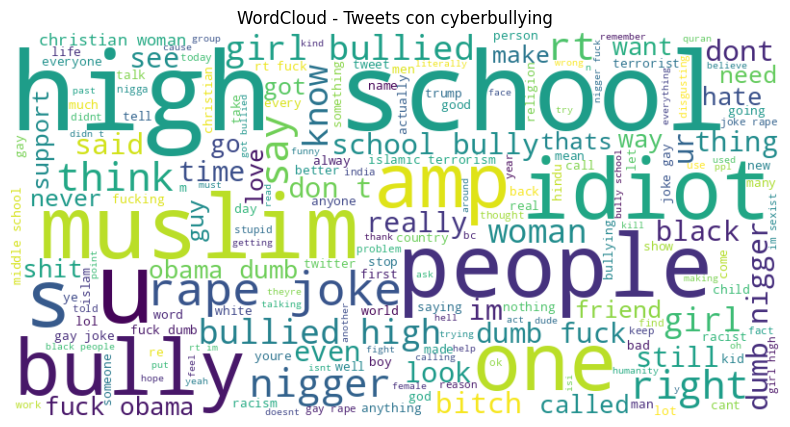

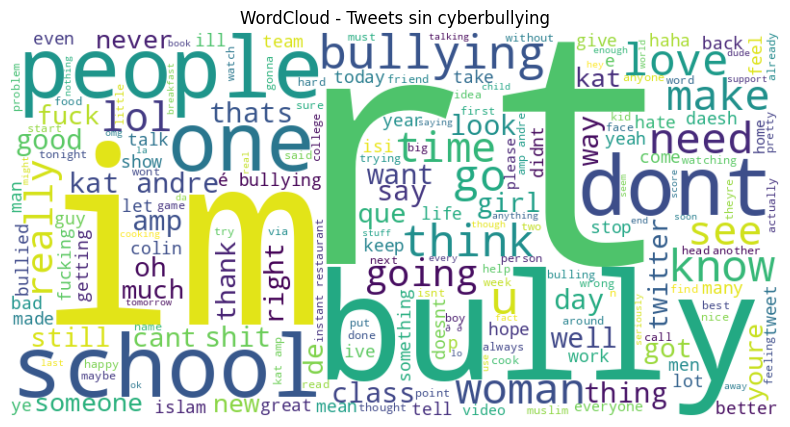

In [ ]:
# WordCloud para tweets con cyberbullying
hate_speech = ' '.join(dataset[dataset['cyberbullying'] == 1]['cleaned_tweet'])
wordcloud_hate = WordCloud(width=800, height=400, background_color='white').generate(hate_speech)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.title('WordCloud - Tweets con cyberbullying')
plt.axis('off')
plt.show()

# WordCloud para tweets sin cyberbullying
non_hate_speech = ' '.join(dataset[dataset['cyberbullying'] == 0]['cleaned_tweet'])
wordcloud_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_speech)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_hate, interpolation='bilinear')
plt.title('WordCloud - Tweets sin cyberbullying')
plt.axis('off')
plt.show()

Podemos ver cómo en los tweets con cyberbullying parece que la palabra 'girl' reduce su tamaño, es decir, deja de ser tan significativa. En cambio, otras palabras que antes pasaban más desapercibidas se han vuelto más representativas, como 'joke', 'rape' o 'nigger'.

Por su parte, los tweets sin cyberbullying parecen haber cambiado el panorama de forma menos notable.

Antes de terminar con este apartado aplicaremos **POS Tagging**, que nos ayudará a identificar patrones gramaticales o filtrar palabras según su tipo, ya que asigna etiquetas gramaticales a cada palabra.

In [ ]:
# Función para aplicar POS tagging
def pos_tagging(text):
    tokens = nltk.word_tokenize(text)  # Primero tokenizamos
    pos_tags = nltk.pos_tag(tokens)  # Luego aplicamos POS tagging
    return ' '.join([f'{word}/{tag}' for word, tag in pos_tags])  # Devolvemos con formato

# Aplicamos POS tagging después de la limpieza del tweet
dataset['pos_tags'] = dataset['cleaned_tweet'].apply(pos_tagging)

print(dataset['pos_tags'].head())

0                      word/NN food/NN crapilicious/JJ
1                                             white/JJ
2       classy/NN whore/NN red/JJ velvet/NN cupcake/NN
3    meh/NN p/NN thanks/NNS head/VBP concerned/VBN ...
4    isi/NN account/NN pretending/VBG kurdish/JJ ac...
Name: pos_tags, dtype: object


Podemos ver algunos ejemplos como "word" y "food" que son etiquetadas como sustantivos (NN), o "white" que está etiquetada como un adjetivo (JJ).

"Classy" y "whore" están etiquetadas como sustantivos (NN), aunque "classy" normalmente sería un adjetivo, el algoritmo ha identificado su uso como un sustantivo.

**Análisis de sentimientos**

Ahora pasaremos a realizar un análisis de sentimientos. Es decir, intentaremos añadir una dimensión emocional a nuestro análisis del texto, ya que la detección de un sentimiento negativo nos puede ayudar a identificar tweets con contenido de odio.

Aplicaremos **HuggingFace** agrupando los tweets por lotes para que no tarde demasiado en ejecutarse.

Aquí corremos el riesgo de perder información si tratamos con tweets significativamente largos.


In [ ]:
# Cargamos el modelo de análisis de sentimiento y el tokenizer correspondiente
sentiment_model = pipeline("sentiment-analysis",
                           model="distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Función para truncar texto a la longitud máxima permitida por el modelo
def truncate_text(text, max_length=512):
    tokenized_text = tokenizer.encode(text, truncation=True, max_length=max_length)
    return tokenizer.decode(tokenized_text, skip_special_tokens=True)

# Función para procesar los textos en lotes con truncamiento
def batch_sentiment_analysis(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        truncated_batch = [truncate_text(text) for text in batch]  # Truncamos cada texto en el batch
        batch_results = sentiment_model(truncated_batch)
        results.extend(batch_results)
    return results

# Aplicamos el análisis de sentimiento en los lotes
texts = dataset['cleaned_tweet'].tolist()
sentiments = batch_sentiment_analysis(texts, batch_size=32)

# Extraemos las etiquetas de sentimiento
dataset['advanced_sentiment'] = [sentiment['label'] for sentiment in sentiments]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 4. Vectorización

Para vectorizar usaremos **TF-IDF**, una técnica de vectorización que convierte el texto en una matriz numérica, donde cada columna representa una palabra y cada fila un documento (un tweet en nuestro caso).

Este método nos ayudará a transformar el texto en una forma adecuada para el procesamiento.

**TF-IDF**

Reduciremos el tamaño de la muestra para que a la hora de realizar modelos y compararlos con BERT coincida el numero de datos.

In [ ]:
# Muestreamos 1000 tweets de cada clase para pruebas
dataset_sampled = dataset.groupby('cyberbullying').apply(lambda x: x.sample(1000)).reset_index(drop=True)

In [ ]:
# Vectorización usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limitamos a 5000 características
    ngram_range=(1, 2),  # Unigramas y bigramas
    stop_words='english',  # Eliminamos las stopwords en inglés
    max_df=0.8,  # Ignoramos los términos que aparecen en más del 80% de los documentos
    min_df=5,  # Ignoramos los términos que aparecen en menos de 5 documentos
    use_idf=True,  # Usa IDF para evitar valores negativos
    smooth_idf=True  # Añade un suavizado para evitar valores negativos
)

X_tfidf_sampled = tfidf_vectorizer.fit_transform(dataset_sampled['cleaned_tweet'])

Vamos a realizar un análisis de tópicos usando Latent Dirichlet Allocation (**LDA**). Dicho análisis nos puede proporcionar información adicional sobre qué temas son más frecuentes en los tweets con cyberbullying.

In [ ]:
# Aplicamos LDA
lda = LDA(n_components=5, random_state=123)  # 5 tópicos
lda.fit(X_tfidf_sampled)

# Mostramos los tópicos más importantes
terms = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Top 10 palabras en el tópico {idx}:")
    print([terms[i] for i in topic.argsort()[-10:]])

Top 10 palabras en el tópico 0:
['need', 'amp', 'thanks', 'make', 'time', 'bullying', 'rape joke', 'gay', 'rape', 'joke']
Top 10 palabras en el tópico 1:
['got', 'look', 'bully', 'high school', 'like', 'high', 'bullied', 'girl', 'rt', 'school']
Top 10 palabras en el tópico 2:
['rt', 'know', 'sure', 'shit', 'bitch', 'dont', 'youre', 'im', 'bully', 'bullying']
Top 10 palabras en el tópico 3:
['andre', 'rt', 'terrorist', 'woman', 'islam', 'christian', 'kat', 'right', 'idiot', 'muslim']
Top 10 palabras en el tópico 4:
['dumb nigger', 'dont', 'dumb fuck', 'think', 'ur', 'white', 'black', 'dumb', 'nigger', 'fuck']


*   **Tópico 0**: Las palabras clave como "rape joke", "bully", y "gay" sugieren que este tópico trata temas relacionados con agresiones verbales, bromas ofensivas, y ciberacoso, probablemente centrado en la orientación sexual y el acoso relacionado.

*   **Tópico 1**: Incluye palabras como "islam", "muslim", y "idiot", que parecen estar relacionadas con discusiones sobre religión, particularmente sobre el Islam, posiblemente con un enfoque en comentarios islamófobos.

*   **Tópico 2**: Palabras como "fucking", "nigger", y "bitch" indican un tópico muy agresivo, lleno de insultos raciales y de género, reflejando un alto nivel de violencia verbal.

*   **Tópico 3**: Este tópico parece menos claro, con palabras en varios idiomas ("da", "eu", "que") junto a "terrorist" y "bullying", lo que sugiere que abarca tanto temas de terrorismo como acoso, pero con un contexto internacional o multilingüe.

*   **Tópico 4**: Con palabras como "high school", "bullied", y "girl", parece estar relacionado con experiencias de acoso escolar, destacando las interacciones sociales en un entorno académico.

Por otro lado, usaremos **embeddings contextuales generados por BERT**, un modelo de transformers. Esto hará que la representación de una palabra **dependa de su contexto**.

**Word Embedding**

Como hemos anunciado antes, dado que los embeddings de BERT pueden ser intensivos en recursos vamos a reducir el tamaño del conjunto de datos mientras probamos el modelo.

In [ ]:
# Carga de modelos y tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Función para generar embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)
    with torch.no_grad():  # Evitamos calcular gradientes para ahorrar memoria
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

In [ ]:
# Generamos embeddings y los guardamos en un archivo para evitar tener que regenerarlos cada vez
bert_embeddings = np.vstack(dataset_sampled['cleaned_tweet'].apply(get_bert_embeddings))
np.save('bert_embeddings.npy', bert_embeddings)

# Cargamos los embeddings desde nuestro archivo
bert_embeddings_loaded = np.load('bert_embeddings.npy')

## 5. Entrenamiento y evaluación de modelos


Vamos a realizar **dos divisiones** de los datos para poder entrenar, una usando TF-IDF y otra con BERT embeddings. También probaremos con **tres modelos** después de realizar una **validación cruzada** para luego decidir cuál es el mejor según su rendimiento.
En ambas probaremos con una partición 80-20.

También, dado el desequilibrio en los datos, utilizaremos **SMOTE** para balancearlos pero SOLO para CountVectorizer y TF-IDF, ya que no es aplicable a embeddings densos.

Crearemos una función que englobe todos estos pasos para agilizar el proceso.

In [ ]:
# Vectorización usando CountVectorizer para Naive Bayes
count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_count_sampled = count_vectorizer.fit_transform(dataset_sampled['cleaned_tweet'])

In [ ]:
# Definimos los modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),  # Usará CountVectorizer
}

# Datasets
datasets = {
    'TF-IDF': X_tfidf_sampled,
    'BERT': bert_embeddings_loaded,
    'Count': X_count_sampled  # Solo para Naive Bayes
}

labels = dataset_sampled['cyberbullying']

# Loop para entrenar y evaluar cada modelo
for vectorizer_name, X in datasets.items():
    # Split en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=123)

    # Aplicamos SMOTE solo si el vectorizador es TF-IDF o Count, y el modelo no es BERT
    if vectorizer_name != 'BERT':
        smote = SMOTE(random_state=123)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    for model_name, model in models.items():
        # Saltamos Naive Bayes si el vectorizador no es 'Count'
        if model_name == 'Naive Bayes' and vectorizer_name != 'Count':
            continue

        print(f"\nTraining {model_name} with {vectorizer_name} features")

        # Validación cruzada
        cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

        print(f"\nResultados de validación cruzada para {model_name} con {vectorizer_name}:")
        print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
        print(f"Precision: {cv_results['test_precision_macro'].mean():.4f}")
        print(f"Recall: {cv_results['test_recall_macro'].mean():.4f}")
        print(f"F1 Score: {cv_results['test_f1_macro'].mean():.4f}")
        print("-" * 80)

        # Entrenamiento del modelo
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Verifizamos si existe overfitting o underfitting:
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        # Evaluación del modelo
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Train Accuracy: {train_score:.4f}")
        print(f"Test Accuracy: {test_score:.4f}")
        print(classification_report(y_test, y_pred))
        print("-" * 80)


Training Logistic Regression with TF-IDF features

Resultados de validación cruzada para Logistic Regression con TF-IDF:
Accuracy: 0.8222
Precision: 0.8276
Recall: 0.8222
F1 Score: 0.8214
--------------------------------------------------------------------------------
Train Accuracy: 0.8848
Test Accuracy: 0.8075
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       207
           1       0.83      0.75      0.79       193

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

--------------------------------------------------------------------------------

Training Random Forest with TF-IDF features

Resultados de validación cruzada para Random Forest con TF-IDF:
Accuracy: 0.8402
Precision: 0.8505
Recall: 0.8401
F1 Score: 0.8389
--------------------------------------------------------------------------------
Train Accuracy: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Resultados de validación cruzada para Logistic Regression con BERT:
Accuracy: 0.7781
Precision: 0.7782
Recall: 0.7781
F1 Score: 0.7781
--------------------------------------------------------------------------------
Train Accuracy: 0.9213
Test Accuracy: 0.8075
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       207
           1       0.80      0.80      0.80       193

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

--------------------------------------------------------------------------------

Training Random Forest with BERT features

Resultados de validación cruzada para Random Forest con BERT:
Accuracy: 0.8100
Precision: 0.8147
Recall: 0.8105
F1 Score: 0.8094
--------------------------------------------------------------------------------
Train Accuracy: 0.9956
Test Accuracy: 0.8225
              precision    reca

**TF-IDF**

  * **Logistic Regression**:  la mayoría de los ejemplos de clase 1 (tweets con cyberbullying) se identifican correctamente, aunque hay algunos falsos positivos.

  * **Random Forest**: es competitivo y ofrece un rendimiento mejor que Logistic Regression, con un accuracy score de 0.8450. Es uno de los modelos con el mejor rendimiento de los que hemos probado.

**BERT**

  * **Logistic Regression**: Aunque BERT es un modelo potente, en este caso, Logistic Regression no ha alcanzado el máximo potencial con las características BERT, posiblemente por problemas de convergencia (según las advertencias de límite de iteraciones).

  * **Random Forest**: Random Forest con BERT mejora levemente el rendimiento respecto a Logistic Regression con BERT pero sin llegar a tener uno de los mejores rendimientos, lo que sugiere que este modelo no sería uno de los más adecuados para manejar características generadas por BERT.

**COUNT**

  * **Logistic Regression**:  Logistic Regression con CountVectorizer funciona incluso mejor que TF-IDF, lo que sugiere que la representación en términos de frecuencia de palabras (Count) es suficiente para este conjunto de datos.

  * **Random Forest**: Sigue siendo una opción sólida para este tipo de tarea.

  * **Naive Bayes**: Naive Bayes con CountVectorizer es menos efectivo que los otros modelos, lo cual es común cuando los datos tienen relaciones complejas que Naive Bayes no captura bien.

Podemos concluir lo siguiente:

1. Random Forest con TF-IDF y Logistic Regression con Count muestran los mejores resultados en términos de precisión, recall y F1-Score.

2. BERT no parece haber mejorado significativamente el rendimiento en estos modelos, lo que podría deberse a problemas de convergencia o a que TF-IDF y Count ya capturan bien la información relevante.

3. Naive Bayes muestra un rendimiento más bajo en general comparado con los otros enfoques.

Por lo tanto, **Logistic Regression con Count y Random Forest con TF-IDF** parecen ser las **opciones más efectivas** para este problema.

**Curva Roc**

Vamos a visualizar el rendimiento de ambos modelos mediante una curva ROC y una curva de precisión. Primero, obtendremos las probabilidades de predicción para cada modelo.

In [ ]:
# Dividimos los datasets
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count_sampled, labels, test_size=0.2, random_state=123)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_sampled, labels, test_size=0.2, random_state=123)

# Aplicamos SMOTE
smote = SMOTE(random_state=123)
X_train_count_smote, y_train_smote = smote.fit_resample(X_train_count, y_train)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

Training Logistic Regression with Count features...


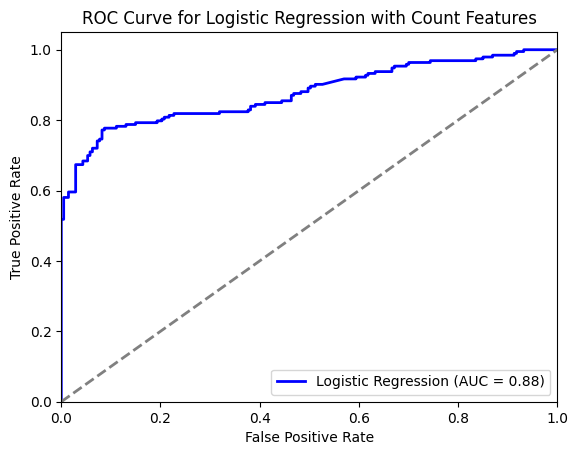

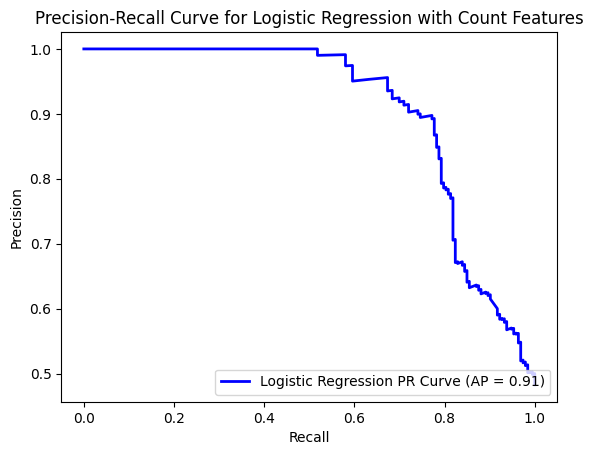

In [ ]:
# Entrenamos y evaluamos Logistic Regression con Count
print("Training Logistic Regression with Count features...")
logistic_model = LogisticRegression()
logistic_model.fit(X_train_count_smote, y_train_smote)
y_pred_proba_logistic = logistic_model.predict_proba(X_test_count)[:, 1]

# Calculamos la curva ROC para Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Calculamos la curva Precision-Recall para Logistic Regression
precision_logistic, recall_logistic, _ = precision_recall_curve(y_test, y_pred_proba_logistic)
average_precision_logistic = average_precision_score(y_test, y_pred_proba_logistic)

plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with Count Features')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(recall_logistic, precision_logistic, color='blue', lw=2, label='Logistic Regression PR Curve (AP = %0.2f)' % average_precision_logistic)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression with Count Features')
plt.legend(loc='lower right')
plt.show()

Training Random Forest with TF-IDF features...


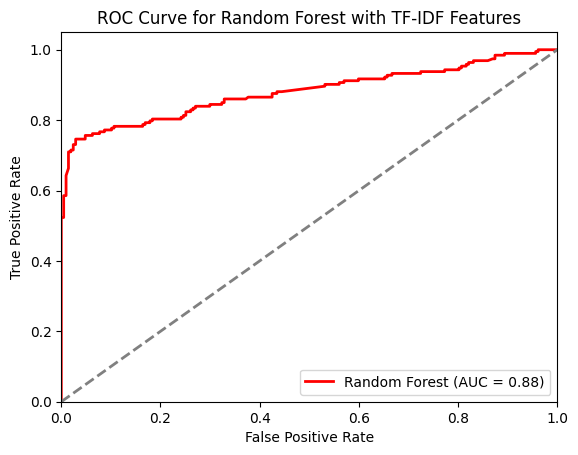

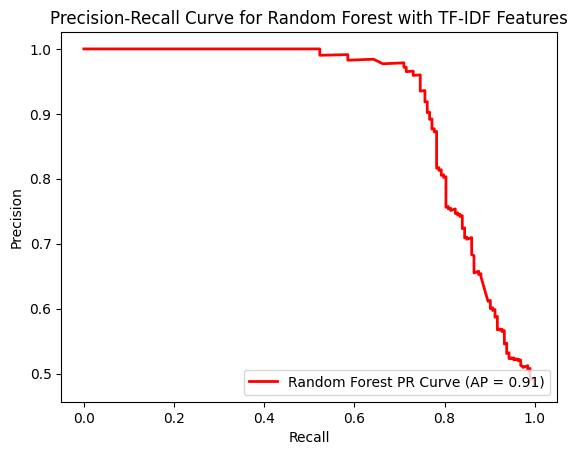

In [ ]:
# Entrenamos y evaluamos Random Forest con TF-IDF
print("Training Random Forest with TF-IDF features...")
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_tfidf_smote, y_train_smote)
y_pred_proba_rf = random_forest_model.predict_proba(X_test_tfidf)[:, 1]

# Calculamos la curva ROC para Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Calculamos la curva Precision-Recall para Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
average_precision_rf = average_precision_score(y_test, y_pred_proba_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest with TF-IDF Features')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(recall_rf, precision_rf, color='red', lw=2, label='Random Forest PR Curve (AP = %0.2f)' % average_precision_rf)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest with TF-IDF Features')
plt.legend(loc='lower right')
plt.show()

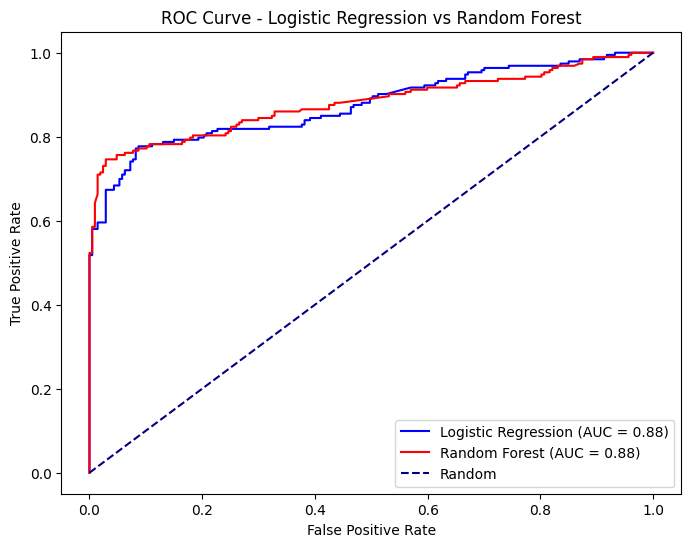

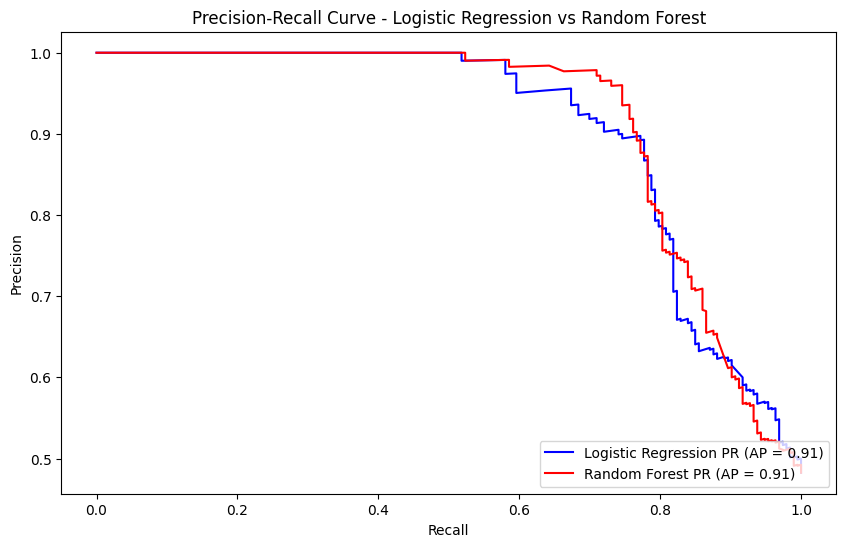

In [ ]:
# Comparamos ambas curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression vs Random Forest')
plt.legend(loc="lower right")
plt.show()

# Comparamos ambas curvas Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall_logistic, precision_logistic, label=f'Logistic Regression PR (AP = {average_precision_logistic:.2f})', color='blue')
plt.plot(recall_rf, precision_rf, label=f'Random Forest PR (AP = {average_precision_rf:.2f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression vs Random Forest')
plt.legend(loc="lower right")
plt.show()

Como podemos ver en los gráficos, ambos modelos ofrecen un rendimiento similar, con valores de AUC y AP bastante altos (0.88 y 0.91, respectivamente).
En el primer gráfico podemos ver que los dos modelos **son efectivos para discriminar entre clases**, aunque pueden tener un pequeño margen de diferencia en ciertos umbrales. Por otra parte, en el segundo gráfico vemos que **son modelos sólidos que equilibran bien la precisión y el recall**, por lo que son adecuados para tareas de clasificación donde ambos aspectos son importantes.

Por último, usaremos **hiperparámetros** para intentar optimizar el rendimiento de nuestro modelo. Los probaremos con los dos modelos que hemos elegido (Logistic Regression y Random Forest con TF-IDF) para encontrar finalmente el mejor modelo.

Vamos a usar **RandomizedSearchCV**, ya que al seleccionar aleatoriamente combinaciones de hiperparámetros para probar, puede ser más rápido (sin dejar de ser eficiente) que GridSearchCV.

In [ ]:
# Hiperparámetros para Logistic Regression
param_dist_logistic = {
    'penalty': ['l1', 'l2'],  # Tipos de penalización
    'C': [0.1, 1, 10, 100],    # Inverso de la regularización
    'solver': ['liblinear', 'saga'],   # Solvers compatibles con l1 y elasticnet
    'max_iter': [100, 200, 300]        # Número máximo de iteraciones
}

# Hiperparámetros para Random Forest
param_dist_random_forest = {
    'n_estimators': [100, 200, 300],  # Lista de valores
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

In [ ]:
# Creamos los hiperparámetros con RandomizedSearchCV
random_search_logistic = RandomizedSearchCV(LogisticRegression(),
                                            param_distributions=param_dist_logistic,
                                            n_iter=20,  # Número de combinaciones a probar
                                            cv=5,       # Número de folds en validación cruzada
                                            scoring='f1_macro', #Teniendo en cuenta el desbalance de clases
                                            n_jobs=-1,
                                            random_state=123)

random_search_random_forest = RandomizedSearchCV(RandomForestClassifier(),
                                                 param_distributions=param_dist_random_forest,
                                                 n_iter=20,   # Número de combinaciones a probar
                                                 cv=5,        # Número de folds en validación cruzada
                                                 scoring='roc_auc', #Teniendo en cuenta el desbalance de clases
                                                 n_jobs=-1,
                                                 random_state=123)

In [ ]:
# Entrenamos y evaluamos Logistic Regression con Count
print("Training Logistic Regression with Count features...")
random_search_logistic.fit(X_train_count_smote, y_train_smote)
print(f"Mejores parámetros para Logistic Regression con Count: {random_search_logistic.best_params_}")
print(f"Mejor Score: {random_search_logistic.best_score_}")

# Evaluamos con los datos de test
best_logistic_model = random_search_logistic.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test_count)

# Calculamos train_score y test_score
train_score = best_logistic_model.score(X_train_count_smote, y_train_smote)
test_score = best_logistic_model.score(X_test_count, y_test)

print(f"\nTrain Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(classification_report(y_test, y_pred_logistic))
print("-" * 80)

# Entrenamos y evaluamos Random Forest con TF-IDF
print("Training Random Forest with TF-IDF features...")
random_search_random_forest.fit(X_train_tfidf_smote, y_train_smote)
print(f"Mejores parámetros para Random Forest con TF-IDF: {random_search_random_forest.best_params_}")

# Evaluamos con los datos de test
best_random_forest_model = random_search_random_forest.best_estimator_
y_pred_random_forest = best_random_forest_model.predict(X_test_tfidf)

# Calculamos train_score y test_score
train_score_rf = best_random_forest_model.score(X_train_tfidf_smote, y_train_smote)
test_score_rf = best_random_forest_model.score(X_test_tfidf, y_test)

print(f"\nTrain Accuracy: {train_score_rf:.4f}")
print(f"Test Accuracy: {test_score_rf:.4f}")
print(classification_report(y_test, y_pred_random_forest))
print("-" * 80)

Training Logistic Regression with Count features...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejores parámetros para Logistic Regression con Count: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'C': 1}
Mejor Score: 0.8325191285000553

Train Accuracy: 0.9535
Test Accuracy: 0.8325
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       207
           1       0.86      0.78      0.82       193

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

--------------------------------------------------------------------------------
Training Random Forest with TF-IDF features...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Mejores parámetros para Random Forest con TF-IDF: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'class_weight': None, 'bootstrap': False}

Train Accuracy: 0.8445
Test Accuracy: 0.8250
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       207
           1       0.96      0.67      0.79       193

    accuracy                           0.82       400
   macro avg       0.86      0.82      0.82       400
weighted avg       0.85      0.82      0.82       400

--------------------------------------------------------------------------------


Parece que **la implantación de hiperparámetros no ha mejorado el rendimiento de los modelos**... Esto puede ser indicativo de overfitting o underfitting, donde el modelo está demasiado ajustado a los datos de entrenamiento o no tiene suficiente capacidad para capturar patrones. También puede ser que la búsqueda no haya encontrado la combinación óptima de parámetros.

Finalmente, sabiendo que ambos modelos sin hiperparámetros tienen la misma precisión en el conjunto de prueba, hay que tener en cuenta que el modelo de Random Forest tiene una precisión ligeramente mayor (0.8505) en comparación con la Logistic Regression (0.8406). Lo mismo pasa con el recall (0.8401 en comparación con la Logistic Regression (0.8302)) y el F1 (0.8389 en comparación con la Logistic Regression (0.8289)).

Sin embargo, Random Forest tiene una alta precisión en el entrenamiento (0.9802) pero una diferencia significativa con la precisión en el test (0.8450), lo que indica que puede estar sobreajustado a los datos de entrenamiento. Esto también ocurre con Logistic Regression pero de forma más leve (0.9517 VS 0.8450)

Como conclusión, a pesar de que Logistic Regression sea un modelo más simple, más interpretable y con menos riesgo de sobreajuste, **nos quedaríamos con el modelo Random Forest con TF-IDF (sin aplicar hiperparámetros)**, ya que ofrece un buen balance entre precisión, recall y f1-score, tanto en validación cruzada como en datos de prueba.